## Script to fit isochrones for ARMADA binaries

#### - We know delta mag in a few bands from speckle or WDS. We know delta mag in H/K bands from interferometry. We know total magnitudes in many bands from literature.
#### - In theory, we know distance from Hipparcos or Gaia (this is weakest point, as they are unresolved binaries!)

#### - Compare photometry to models using isochrones package

###### The python isochrones package is needed to run this notebook: https://isochrones.readthedocs.io/en/latest/
###### As suggested in the user guide, I prefer installing isochrones in a separate conda environment. Hence, this environment needs to be activated before running jupyter lab

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import random
from astroquery.simbad import Simbad
from uncertainties import ufloat,unumpy
from uncertainties.umath import *
import pandas as pd

from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone
Mist_iso = MIST_Isochrone()
Mist_evoTrack = MIST_EvolutionTrack()

%matplotlib inline

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
font = {'family': 'times new roman',
        'color':  'Black',
        'weight': 'normal',
        'size': 16,
        }

In [3]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

In [4]:
## Add quantities of interest to Simbad query -- for total magnitudes
##
## This is a good first check, but for for each target we will eventually 
## want to do a deeper literature search to make sure we are using 
## all available photometry. We should record this in the spreadsheet.

Simbad.add_votable_fields('flux(U)')
Simbad.add_votable_fields('flux(B)')
Simbad.add_votable_fields('flux(V)')
Simbad.add_votable_fields('flux(G)')
Simbad.add_votable_fields('flux(R)')
Simbad.add_votable_fields('flux(I)')
Simbad.add_votable_fields('flux(J)')
Simbad.add_votable_fields('flux(H)')
Simbad.add_votable_fields('flux(K)')

Simbad.add_votable_fields('flux_error(U)')
Simbad.add_votable_fields('flux_error(B)')
Simbad.add_votable_fields('flux_error(V)')
Simbad.add_votable_fields('flux_error(G)')
Simbad.add_votable_fields('flux_error(R)')
Simbad.add_votable_fields('flux_error(I)')
Simbad.add_votable_fields('flux_error(J)')
Simbad.add_votable_fields('flux_error(H)')
Simbad.add_votable_fields('flux_error(K)')

In [5]:
## Setup paths
dirpath = "/Users/suzutsuki-ch/Work/ARMADA/"
save_directory = "/Users/suzutsuki-ch/Work/ARMADA/Targets" ## path for saved files
armada_file = "/Users/suzutsuki-ch/Work/ARMADA/full_target_list.csv" ## path to csv target file
note = 'Chi' ## note for saved files (e.g. 'hip' for hipparcos distance, or 'gaia')

## First select a binary target and get info from csv file

In this part, user can specify a target and query from simbad to obtain its total apparent magnitude. With the measured flux ratio, user can split the total observed magnitude in a system to separate magnitudes of individual stars. The formula is given below.
$$\Delta M = -2.5\log_{10}(f_1/f_2)~~~\Rightarrow~~~f_1 = 10^{-0.4\Delta M}f_2$$
Let $m$ be the total apparent magnitude queried from simbad, we can calculate apparent magnitude $m_1$, $m_2$ for individual targets.
$$m_1 = m-2.5\log_{10}\frac{f_1+f_2}{f_1}$$
$$m_2 = m-2.5\log_{10}\frac{f_1+f_2}{f_2}$$
To convert everything to absolute magnitude, we subtract distance modulus from the results:
$$M_i = m_i - 5\log_{10}(d/10pc)$$
We assume no extinction, and the two stars are of equal distance to us.

Note that we will likely fit to observables (i.e. total magnitude and flux ratios)

In [6]:
target_hd = '6456'
df = pd.read_csv(armada_file,dtype=object)

## Create directory for saved files, if it doesn't already exist
directory = "%s/HD_%s/"%(save_directory,target_hd)
if not os.path.exists(directory):
    print("Creating directory")
    os.makedirs(directory)

In [7]:
idx = np.where(df['HD']==target_hd)[0][0]

distance_gaia = ufloat(float(df['Gaia_distance (pc)'][idx]),float(df['Gaia_distance_err (pc)'][idx]))
distance_hip = ufloat(float(df['HIP_distance (pc)'][idx]),float(df['HIP_distance_err (pc)'][idx]))
print("distance gaia = ",distance_gaia)
print("distance hip = ",distance_hip)


cdiff_h = ufloat(float(df['dmag_h'][idx]),float(df['dmag_h_err'][idx]))
cdiff_k = ufloat(float(df['dmag_k'][idx]),float(df['dmag_k_err'][idx]))
cdiff_i = ufloat(float(df['dmag_speckle_i'][idx]),float(df['dmag_speckle_i_err'][idx]))
cdiff_v_speckle = ufloat(float(df['dmag_speckle_v'][idx]),float(df['dmag_speckle_v_err'][idx]))
cdiff_v_wds = ufloat(float(df['dmag_wds_v'][idx]),float(df['dmag_wds_v_err'][idx]))

distance gaia =  nan+/-nan
distance hip =  84+/-5


In [8]:
cdiff_k = ufloat(0.43,0.1)
#cdiff_h = ufloat(np.nan,np.nan)

In [9]:
fratio_h = 10**(cdiff_h/2.5)
fratio_k = 10**(cdiff_k/2.5)
fratio_i = 10**(cdiff_i/2.5)
fratio_v_speckle = 10**(cdiff_v_speckle/2.5)
fratio_v_wds = 10**(cdiff_v_wds/2.5)

print("fratio: v_speckle, v_wds, i_mag, h_mag, k_mag = ")
print(fratio_v_speckle,',',fratio_v_wds,',',fratio_i,',',fratio_h,',',fratio_k)

fratio: v_speckle, v_wds, i_mag, h_mag, k_mag = 
2.11+/-0.29 , 2.2+/-0.5 , 1.91+/-0.26 , 2.1+/-0.4 , 1.49+/-0.14


In [10]:
## choose which distance to use -- not necessarily obvious! We may want to compare both
# distance = distance_hip
# Choosing a new distance form kervella catalogue
distance = ufloat(87.9, 0.68)

**Calculate the total dynamical mass using the Kervella catalogue**

In [11]:
# df.columns

In [12]:
a_rad = ufloat(float(df['a (mas)'][idx]),float(df['a_err (mas)'][idx]))/1000/206264.806247
a_au = (distance*a_rad)*206264.806
P_yr = ufloat(float(df['P (yr)'][idx]),float(df['P_err (yr)'][idx]))
M_dyn = a_au**3/P_yr**2
print("dynamical mass: %.4f +/- %.4f " % (M_dyn.n, M_dyn.s))

dynamical mass: 4.9639 +/- 0.1161 


## Generating SED for individual components

In [13]:
## query total magnitudes and errors from Simbad
query = Simbad.query_object('HD %s'%target_hd)

ktot = ufloat(query['FLUX_K'][0],query['FLUX_ERROR_K'][0])
utot = ufloat(query['FLUX_U'][0],query['FLUX_ERROR_U'][0])
btot = ufloat(query['FLUX_B'][0],query['FLUX_ERROR_B'][0])
rtot = ufloat(query['FLUX_R'][0],query['FLUX_ERROR_R'][0])
itot = ufloat(query['FLUX_I'][0],query['FLUX_ERROR_I'][0])
htot = ufloat(query['FLUX_H'][0],query['FLUX_ERROR_H'][0])
jtot = ufloat(query['FLUX_J'][0],query['FLUX_ERROR_J'][0])
vtot = ufloat(query['FLUX_V'][0],query['FLUX_ERROR_V'][0])
gtot = ufloat(query['FLUX_G'][0],query['FLUX_ERROR_G'][0])


print("U,B,V,R,Gaia_G,I,J,H,K = ")
print(utot,',',btot,',',vtot,',',rtot,',',gtot,',',itot,',',jtot,',',htot,',',ktot)

U,B,V,R,Gaia_G,I,J,H,K = 
5.260000228881836+/-nan , 5.263+/-0.014 , 5.273+/-0.009 , nan+/-nan , 5.268+/-0.006 , nan+/-nan , 5.24+/-0.05 , 5.301+/-0.021 , 5.265+/-0.027


/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2801: UserWarning: Warning: converting a masked element to nan.
  self._std_dev = CallableStdDev(std_dev)
/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  value = float(value)


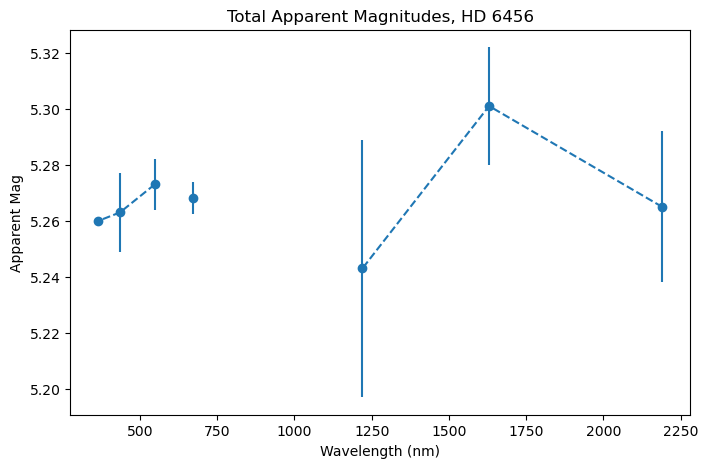

In [14]:
x = np.array([2190,1630,1220,832,673,658,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,itot.nominal_value,
              gtot.nominal_value,rtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])
yerr = np.array([ktot.std_dev,htot.std_dev,jtot.std_dev,itot.std_dev,gtot.std_dev,
                 rtot.std_dev,vtot.std_dev,btot.std_dev,utot.std_dev])

plt.title("Total Apparent Magnitudes, HD %s"%target_hd)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Apparent Mag")
plt.errorbar(x,y,yerr,fmt='o--')
plt.savefig("%s/HD_%s_%s_total_mags.pdf"%(directory,target_hd,note))
plt.show()

In [15]:
x_notnan = np.array([2190,1630,1220,673,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y_notnan = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,gtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])

In [16]:
data_wave = np.array([551,562,832,1630,2190]) ## wavelengths of our speckle + interferometry data, CHECK THESE

## Compute individual magnitudes from flux ratios and total magnitudes
## Mostly for plotting. We probably won't fit to these in the end. 

k1 = -2.5*log10(10**(-ktot/2.5)/(1+10**(-cdiff_k/2.5)))
k2 = cdiff_k + k1

h1 = -2.5*log10(10**(-htot/2.5)/(1+10**(-cdiff_h/2.5)))
h2 = cdiff_h + h1

i1 = -2.5*log10(10**(-itot/2.5)/(1+10**(-cdiff_i/2.5)))
i2 = cdiff_i + i1

v_speckle1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_v_speckle/2.5)))
v_speckle2 = cdiff_v_speckle + v_speckle1

v_wds1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_v_wds/2.5)))
v_wds2 = cdiff_v_wds + v_wds1

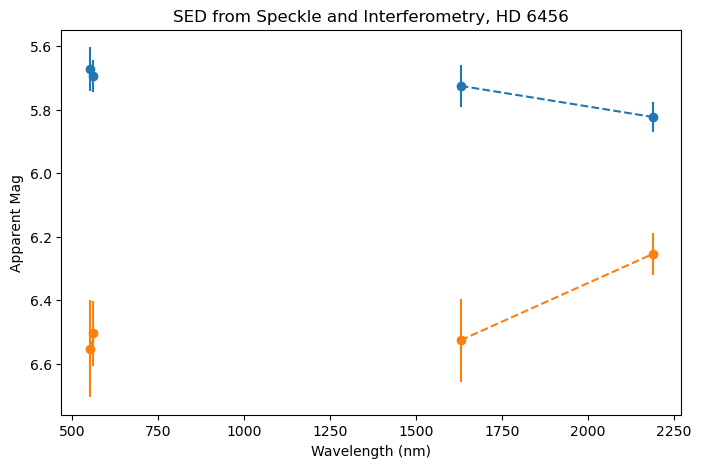

In [17]:
p1 = np.array([v_wds1.nominal_value,v_speckle1.nominal_value,i1.nominal_value,h1.nominal_value,k1.nominal_value])
p1err = np.array([v_wds1.std_dev,v_speckle1.std_dev,i1.std_dev,h1.std_dev,k1.std_dev])
p2 = np.array([v_wds2.nominal_value,v_speckle2.nominal_value,i2.nominal_value,h2.nominal_value,k2.nominal_value])
p2err = np.array([v_wds2.std_dev,v_speckle2.std_dev,i2.std_dev,h2.std_dev,k2.std_dev])

plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--')
plt.errorbar(data_wave,p2,p2err,fmt='o--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,note))
plt.show()

## Now we want to use this information to fit isochrones

#### Generate tracks of multiple ages at chosen metallicity

In [18]:
import tqdm

In [20]:
feh = -0.46 ## we will want to look up this value for each target
Av = 0.0 ## targets are nearby, so extinction should be negligible

log_age_start = 6 ## starting age
log_age_size = 0.5 ## step size
log_age_steps = 7 ## number of steps

paramList  = [np.array([log_age_start,feh])+np.array([log_age_size,0])*i for i in range(0,log_age_steps)]

isoList = [Mist_iso.isochrone(param[0],param[1]) for param in paramList] 
isoList[0].head()

,eep,age,feh,mass,initial_mass,radius,density,logTeff,Teff,logg,...,H_mag,K_mag,G_mag,BP_mag,RP_mag,W1_mag,W2_mag,W3_mag,TESS_mag,Kepler_mag
62,62.0,6.0,-0.431021,0.109384,0.109384,0.980144,0.164272,3.508683,3226.279459,3.489182,...,4.770745,4.559092,8.312007,9.724663,7.195070,4.449165,4.253865,4.122261,7.105392,8.328646
63,63.0,6.0,-0.431021,0.113531,0.113531,1.001057,0.160068,3.509973,3235.881606,3.485456,...,4.712154,4.501667,8.246036,9.648542,7.132610,4.394253,4.201994,4.071170,7.043954,8.261039
64,64.0,6.0,-0.431021,0.117668,0.117668,1.021871,0.156003,3.511253,3245.424865,3.482159,...,4.654903,4.445554,8.181301,9.573611,7.071390,4.340591,4.151356,4.021303,6.983763,8.194659
65,65.0,6.0,-0.431021,0.121788,0.121788,1.042598,0.152066,3.512516,3254.879038,3.479242,...,4.598952,4.390714,8.117808,9.499925,7.011402,4.288140,4.101901,3.972607,6.924805,8.129521
66,66.0,6.0,-0.431020,0.125898,0.125898,1.063377,0.148207,3.513761,3264.222940,3.476595,...,4.543982,4.336830,8.055299,9.427275,6.952374,4.236589,4.053315,3.924767,6.866801,8.065373


#### We need to add B, V, and I mag to the output of isochrones (H and K included by default)
#### Using bolometric correction grid to compute these model magnitudes

In [21]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
bc_grid_B = MISTBolometricCorrectionGrid(['B'])
bc_grid_V = MISTBolometricCorrectionGrid(['V'])
bc_grid_I = MISTBolometricCorrectionGrid(['I'])

In [22]:
# Check first few rows of bolometric correction grid
bc_grid_B.df.head()
#bc_grid_V.df.head()
#bc_grid_I.df.head()

B
Teff   logg [Fe/H] Av            
2500.0 -4.0 -4.0   0.00 -7.714880
                   0.05 -7.773749
                   0.10 -7.832595
                   0.15 -7.891418
                   0.20 -7.950218

In [23]:
# Calculating the bolometric correction in B band
Mbol_B = []
for i,iso in enumerate(isoList):
    Mbol_B.append(bc_grid_B.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())   
B = []
for i,iso in enumerate(isoList):
    B.append(iso['Mbol'] - Mbol_B[i])
    
# Calculating the bolometric correction in V band
Mbol_V = []
for i,iso in enumerate(isoList):
    Mbol_V.append(bc_grid_V.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
V = []
for i,iso in enumerate(isoList):
    V.append(iso['Mbol'] - Mbol_V[i])

# Calculating the bolometric correction in I band
Mbol_I = []
for i,iso in enumerate(isoList):
    Mbol_I.append(bc_grid_I.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
I = []
for i,iso in enumerate(isoList):
    I.append(iso['Mbol'] - Mbol_I[i])
    
H = []
for iso in isoList:
    H.append(iso['H_mag'])

K = []
for iso in isoList:
    K.append(iso['K_mag'])

## Let's take a look at the HR diagram
#### No fitting at this point, but good to estimate starting value for age

In [24]:
print("Distance = ", distance, 'pc')
d_modulus = 5*log10(distance)-5
print("Distance Modulus = ", d_modulus)

Distance =  87.9+/-0.7 pc
Distance Modulus =  4.720+/-0.017


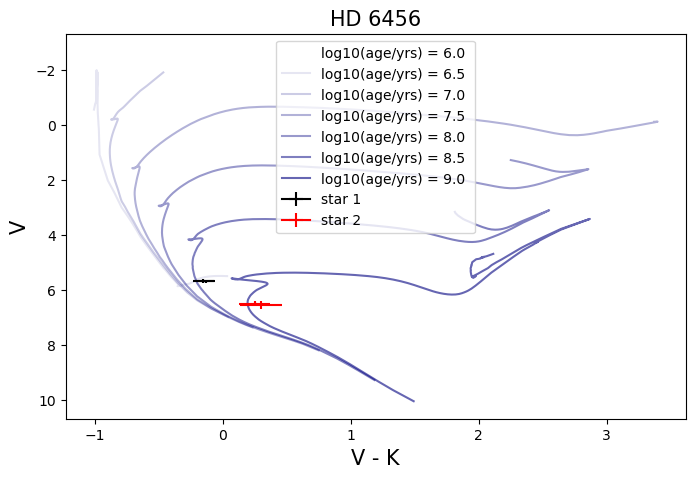

In [25]:
## change the range of plotted values in isochrones "by eye"
iso_start = 100
iso_end = 500

## Choose x/y axis. For example, V-H vs V
xval1 =v_speckle1-k1 ## component 1
yval1 = v_speckle1
xval2 = v_speckle2-k2 ## component 2
yval2 = v_speckle2

xval3 =v_wds1-k1 ## component 1
yval3 = v_wds1
xval4 = v_wds2-k2 ## component 2
yval4 = v_wds2

xlabel = "V - K"
ylabel = "V"

for i,iso in enumerate(isoList):
    
    ## make sure model matches data magnitudes
    modelx = V[i][iso_start:iso_end] - K[i][iso_start:iso_end]
    modely = V[i][iso_start:iso_end] + d_modulus.nominal_value
    
    plt.plot(modelx,modely,label = f"log10(age/yrs) = {6+0.5*i} ", color="navy", alpha=1 - (1 - 0.1*i))

## make plot
plt.errorbar([xval1.nominal_value,xval3.nominal_value],[yval1.nominal_value, yval3.nominal_value],
             xerr = [xval1.std_dev,xval3.std_dev], yerr = [yval1.std_dev,yval3.std_dev],
             color="black", label="star 1")
plt.errorbar([xval2.nominal_value,xval4.nominal_value],[yval2.nominal_value, yval4.nominal_value],
             xerr = [xval2.std_dev,xval4.std_dev], yerr = [yval2.std_dev,yval4.std_dev],
             color="red", label="star 2")

        
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.gca().invert_yaxis()
plt.title("HD %s"%target_hd, fontsize = 15)
plt.legend()
plt.savefig("%s/HD_%s_%s_hr_diagram.png"%(directory,target_hd,note))
plt.show()

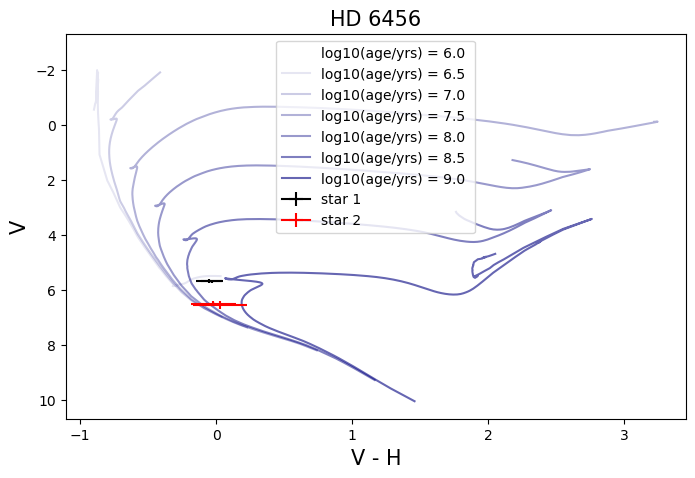

In [26]:
## change the range of plotted values in isochrones "by eye"
iso_start = 100
iso_end = 500

## Choose x/y axis. For example, V-H vs V
xval1 =v_speckle1-h1 ## component 1
yval1 = v_speckle1
xval2 = v_speckle2-h2 ## component 2
yval2 = v_speckle2

xval3 =v_wds1-h1 ## component 1
yval3 = v_wds1
xval4 = v_wds2-h2 ## component 2
yval4 = v_wds2

xlabel = "V - H"
ylabel = "V"

for i,iso in enumerate(isoList):
    
    ## make sure model matches data magnitudes
    modelx = V[i][iso_start:iso_end] - H[i][iso_start:iso_end]
    modely = V[i][iso_start:iso_end] + d_modulus.nominal_value
    
    plt.plot(modelx,modely,label = f"log10(age/yrs) = {6+0.5*i} ", color="navy", alpha=1 - (1 - 0.1*i))

## make plot
plt.errorbar([xval1.nominal_value,xval3.nominal_value],[yval1.nominal_value, yval3.nominal_value],
             xerr = [xval1.std_dev,xval3.std_dev], yerr = [yval1.std_dev,yval3.std_dev],
             color="black", label="star 1")
plt.errorbar([xval2.nominal_value,xval4.nominal_value],[yval2.nominal_value, yval4.nominal_value],
             xerr = [xval2.std_dev,xval4.std_dev], yerr = [yval2.std_dev,yval4.std_dev],
             color="red", label="star 2")

        
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.gca().invert_yaxis()
plt.title("HD %s"%target_hd, fontsize = 15)
plt.legend()
plt.savefig("%s/HD_%s_%s_hr_diagram.png"%(directory,target_hd,note))
plt.show()

## Now let's do a MCMC fit for masses and age

In the fitting, the likelihood function is given by:
$$\mathcal{L} = \exp\left(-\frac{1}{2}\sum_i \left(\frac{\Delta M_{i,\text{tot}}}{\sigma_{\Delta_{M_{i,\text{tot}}}}}\right)^2 + \left(\frac{\Delta (M_{i,1}-M_{i,2})}{\sigma_{\Delta (M_{i,1}-M_{i,2})}}\right)^2\right)$$

Hence, we are fitting to the total magnitudes and color differences. The model functions below returns an $\chi$-array. 

In [27]:
from isochrones import get_ichrone
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import corner
tracks = get_ichrone('mist', tracks=True, accurate=True)

In [28]:
## Objective function to be minimized for lmfit
def isochrone_model(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    D_mag_model = mag2_model - mag1_model
    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

### A new isochorne model that interpolate the model photometry to add more constraint

In [29]:
bc_grid_U = MISTBolometricCorrectionGrid(['U'])
bc_grid_B = MISTBolometricCorrectionGrid(['B'])
bc_grid_V = MISTBolometricCorrectionGrid(['V'])
bc_grid_R = MISTBolometricCorrectionGrid(['R'])
bc_grid_I = MISTBolometricCorrectionGrid(['I'])
bc_grid_Z = MISTBolometricCorrectionGrid(['z'])
bc_grid_J = MISTBolometricCorrectionGrid(['J'])

In [30]:
# This cell gives detail to the wavelength used in the BC grid
[bc_grid_Z.get_band('z')]

[('SDSSugriz', 'SDSS_z')]

In [31]:
'''
Objective function to be minimized for lmfit
This function is an imporovement from isochrone_model. It uses bolometric correction to obtain more constraints for fitting.
'''
def isochrone_model_v2(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    D_mag_model = mag2_model - mag1_model
    
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    
    ## Bessel_U, Bessel_B, Bessel_V, Bessel_R, Gaia_G, Bessel_I, SDSS_z, 2MASS_J, 2MASS_H, 2MASS_K
    Wavelengths = np.array([365, 445, 551, 658, 673, 806, 905, 1250, 1650, 2150])

    mag1_model = np.array([(a1['Mbol'] - bc_grid_U.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                           (a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_R.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_J.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_U.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                           (a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_R.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_J.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))

    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

In [32]:
'''
Objective function to be minimized for lmfit
This function is an imporovement from isochrone_model_v2.
V2 model did not include error from distance measurement into fitting, v3 fixed this. 
Since doing so yields larger error bars to the total magnitude data, we may expect a smaller chi^2 value. 
However, it will also cause the standard deviation from MCMC be larger.
'''
def isochrone_model_v3(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    D_mag_model = mag2_model - mag1_model
    
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    
    ## Bessel_U, Bessel_B, Bessel_V, Bessel_R, Gaia_G, Bessel_I, SDSS_z, 2MASS_J, 2MASS_H, 2MASS_K
    Wavelengths = np.array([365, 445, 551, 658, 673, 806, 905, 1250, 1650, 2150])

    mag1_model = np.array([(a1['Mbol'] - bc_grid_U.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                           (a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_R.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_J.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_U.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                           (a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_R.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_J.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))

    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

In [33]:
'''
Objective function to be minimized for lmfit
This function is a modification from isochrone_model_v3.
Instead fitting the two individual masses, we fit mass of the main component and the total mass. 
One can use this to check the consistency between fits as well as directly obtain total mass from fits.
'''
def isochrone_model_v3_II(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2 - m1, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    D_mag_model = mag2_model - mag1_model
    
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    
    ## Bessel_U, Bessel_B, Bessel_V, Bessel_R, Gaia_G, Bessel_I, SDSS_z, 2MASS_J, 2MASS_H, 2MASS_K
    Wavelengths = np.array([365, 445, 551, 658, 673, 806, 905, 1250, 1650, 2150])

    mag1_model = np.array([(a1['Mbol'] - bc_grid_U.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                           (a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_R.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_J.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_U.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                           (a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_R.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_J.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))

    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

#### Important note: If the age is too high for a given mass, the model photometry will return all nan (massive stars have shorter lifetimes). This can kill the fitting. 
##### Here we will set a max mass and age for fitting. This could take some tweaking. If chosen max mass is too high (and hence age too low), you may miss the solution! The MCMC posteriors should help...

In [34]:
max_mass = 4 ## choose a maximum mass to fit for, you then need to set an appropriate maximum age!
min_feh = 0
max_feh = 0

age_test = np.linspace(6,9,150)
for tt in age_test:
    a1 = tracks.generate(max_mass, tt, min_feh, return_dict=True)
    if np.isnan(a1['Mbol']):
        print("Max log(age) = %s, for mass = %s Msun"%(tt, max_mass))
        max_age = tt
        break

Max log(age) = 8.29530201342282, for mass = 4 Msun


In [35]:
## if you want to set a lower max age:
max_age = 9.5

In [36]:
## Choose observables for fitting
TOT_Mag = np.array([utot, btot, vtot, rtot, itot, jtot, htot, ktot]) - d_modulus
DiffM = np.array([cdiff_v_wds, cdiff_v_speckle, cdiff_i, cdiff_h, cdiff_k])

In [37]:
TOT_Mag

array([0.5400558535129765+/-nan, 0.5430556360752323+/-0.02186766144393985,
       0.5530553881199101+/-0.019057665070865506, nan+/-nan, nan+/-nan,
       0.5230556551487187+/-0.04897136523676332,
       0.5810557428867558+/-0.02689227757249103,
       0.5450554911167362+/-0.031799286827634644], dtype=object)

In [38]:
## start with a chi2 fit (this does not always work)

## NOTE --> Since isochrones has a fixed age grid, the fitting currently fails to optimize this parameter
## We can search age on a grid, or change the default step size for the parameter

params = Parameters()
params.add('age',   value= 8.6, max=10)
params.add('mass1', value= 2.2)
params.add('mass2', value= 3.8)
params.add('feh', value = -0.46, vary=False)#, min=-0.5, max=0.5)

minner = Minimizer(isochrone_model_v3_II, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                         unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                         d_modulus.nominal_value, Av),nan_policy='omit')
result = minner.minimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 10
    # variables        = 3
    chi-square         = 30.5583100
    reduced chi-square = 4.36547286
    Akaike info crit   = 17.1705157
    Bayesian info crit = 18.0782710
##  Warning: uncertainties could not be estimated:
    age:    at initial value
[[Variables]]
    age:    8.60000000 (init = 8.6)
    mass1:  2.21844680 (init = 2.2)
    mass2:  4.05442061 (init = 3.8)
    feh:   -0.46 (fixed)


In [39]:
np.linspace(6,9,100)[30]

6.909090909090909

In [40]:
ResultArr = []

i = 0
for age in tqdm.tqdm(np.linspace(6,7,24)):

    params = Parameters()
    params.add('age',   value= age)
    params.add('mass1', value= 2)
    params.add('mass2', value= 3.8)
    params.add('feh', value = -0.46, vary=False)#, min=-0.5, max=0.5)

    minner = Minimizer(isochrone_model_v3_II, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                             unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                             d_modulus.nominal_value, Av), nan_policy='omit')
    result_test = minner.minimize()

    ResultArr.append([result_test.redchi, result_test.params])
    
    if i%5==0: print(i)

    i += 1

  4%|▍         | 1/24 [00:00<00:02,  7.67it/s]

0


 33%|███▎      | 8/24 [00:02<00:04,  3.26it/s]

5


 58%|█████▊    | 14/24 [00:03<00:01,  7.80it/s]

10


 79%|███████▉  | 19/24 [00:03<00:00, 12.99it/s]

15
20


100%|██████████| 24/24 [00:03<00:00,  6.35it/s]


In [41]:
i = 0
for age in tqdm.tqdm(np.linspace(7,9,40)):

    params = Parameters()
    params.add('age',   value= age)
    params.add('mass1', value= 2)
    params.add('mass2', value= 3.8)
    params.add('feh', value = -0.46, vary=False)#, min=-0.5, max=0.5)

    minner = Minimizer(isochrone_model_v3_II, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                             unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                             d_modulus.nominal_value, Av), nan_policy='omit')
    result_test = minner.minimize()

    ResultArr.append([result_test.redchi, result_test.params])
    
    if i%5==0: print(i)

    i += 1


 10%|█         | 4/40 [00:00<00:01, 35.46it/s]

0
5


 40%|████      | 16/40 [00:00<00:00, 31.60it/s]

10
15


 70%|███████   | 28/40 [00:00<00:00, 29.60it/s]

20
25


 95%|█████████▌| 38/40 [00:01<00:00, 35.44it/s]

30
35


100%|██████████| 40/40 [00:01<00:00, 27.40it/s]


In [62]:
minChi2 = np.min(np.abs(np.array(ResultArr)[:,0]))
list(np.array(ResultArr)[:,0]).index(minChi2)

/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_48070/3455388671.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minChi2 = np.min(np.abs(np.array(ResultArr)[:,0]))
/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_48070/3455388671.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list(np.array(ResultArr)[:,0]).index(minChi2)


59

/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_50015/1707823048.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for a in list(np.array(ResultArr)[:,1]):
/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_50015/1707823048.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(AgeList,list(np.array(ResultArr)[:,0]),alpha=0.6,marker="+",color="blue")
/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_50015/1707823048.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a lis

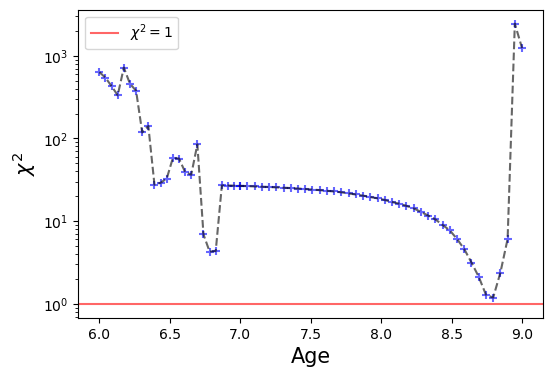

In [44]:
AgeList = []
for a in list(np.array(ResultArr)[:,1]):
    AgeList.append(a['age'].value)

plt.figure(figsize=(6,4))
plt.scatter(AgeList,list(np.array(ResultArr)[:,0]),alpha=0.6,marker="+",color="blue")
plt.plot(AgeList,list(np.array(ResultArr)[:,0]),alpha=0.6,ls="--",color="black")
plt.axhline(y=1,color="red",alpha=0.6, label=r"$\chi^2=1$")
plt.legend()
plt.yscale("log")
plt.xlabel('Age',fontsize=15)
plt.ylabel(r'$\chi^2$',fontsize=15)
plt.savefig("%s/HD_%s_%s_best_chi.png"%(directory,target_hd,"m1andtot"), dpi=240)

In [45]:
## start with a chi2 fit (this does not always work)

## NOTE --> Since isochrones has a fixed age grid, the fitting currently fails to optimize this parameter
## We can search age on a grid, or change the default step size for the parameter

params = Parameters()
params.add('age',   value= 8.75, min=7.6)
params.add('mass1', value= 2.2)
params.add('mass2', value= 3.8)
params.add('feh', value = -0.46, vary=False)#, min=-0.5, max=0.5)

minner = Minimizer(isochrone_model_v3_II, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                         unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                         d_modulus.nominal_value, Av),nan_policy='omit')
result = minner.minimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 10
    # variables        = 3
    chi-square         = 8.52418624
    reduced chi-square = 1.21774089
    Akaike info crit   = 4.40322470
    Bayesian info crit = 5.31097997
##  Warning: uncertainties could not be estimated:
    age:    at initial value
[[Variables]]
    age:    8.75000000 (init = 8.75)
    mass1:  2.06856473 (init = 2.2)
    mass2:  3.86263317 (init = 3.8)
    feh:   -0.46 (fixed)


In [46]:
## Setup MCMC fit
emcee_params = result.params.copy()
nwalkers = 2*len(emcee_params)
steps = 20000
burn = 5000
thin = 25

In [73]:
nwalkers

8

In [74]:
emcee_params

name,value,initial value,min,max,vary
age,8.75000000,8.75,7.60000000,inf,True
mass1,2.06856473,2.2,-inf,inf,True
mass2,3.86263317,3.8,-inf,inf,True
feh,-0.46000000,-0.46,-inf,inf,False


In [76]:
## Do MCMC fit (this cell could take some time, depending on steps)
# np.random.seed(5)
minner = Minimizer(isochrone_model_v3_II, emcee_params, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                            unumpy.nominal_values(DiffM),
                                                            unumpy.std_devs(TOT_Mag),
                                                            unumpy.std_devs(DiffM),
                                                            d_modulus.nominal_value, Av),
                   nan_policy='omit')
result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
print(report_fit(result))

100%|██████████| 20000/20000 [02:06<00:00, 157.82it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 160000
    # data points      = 10
    # variables        = 3
    chi-square         = 8.00868385
    reduced chi-square = 1.14409769
    Akaike info crit   = 3.77941341
    Bayesian info crit = 4.68716869
[[Variables]]
    age:    8.76985793 +/- 0.02875667 (0.33%) (init = 8.75)
    mass1:  2.05080856 +/- 0.02858185 (1.39%) (init = 2.068565)
    mass2:  3.83724307 +/- 0.04128422 (1.08%) (init = 3.862633)
    feh:   -0.46 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(age, mass1)   = -0.945
    C(age, mass2)   = -0.942
    C(mass1, mass2) = 0.851
None


In [ ]:
result.params['mass1']+result.params['mass2']
result.params['mass2']

#### Now let's plot some MCMC outputs
##### Need to make more plots to check convergence, etc

In [82]:
chains = result.flatchain

## save chains (so we don't need to run large ones again)
print(chains.shape)
np.save("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"m1andtot"),chains)

(4800, 3)


In [84]:
## load chains -- NOTE: Could start from here if a run has already been completed
chains = np.load("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"m1andtot"))

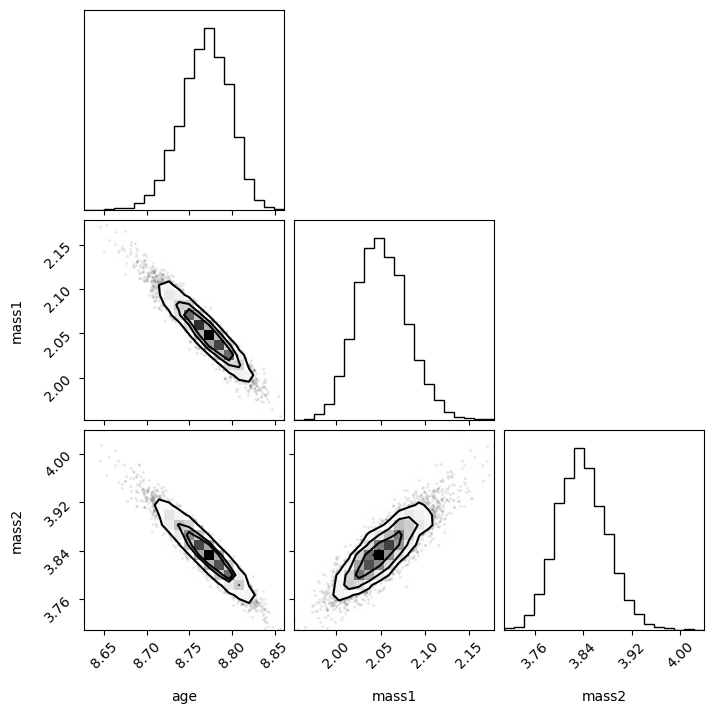

In [85]:
try:
    emcee_plot = corner.corner(chains,labels=result.var_names)
    plt.savefig('%s/HD_%s_%s_corner.jpg'%(directory,target_hd,"m1andtot"))
except:
    print(result.var_names)
    emcee_plot = corner.corner(chains)
    plt.savefig('%s/HD_%s_%s_corner.png'%(directory,target_hd,"m1andtot"))

In [87]:
best_M = ufloat(3.83724307, 0.04128422)
Mdiff = (M_dyn - best_M).n
Mdiff_e = (M_dyn - best_M).s
print("Difference in mass: %.4f +/- %.4f" %(Mdiff,Mdiff_e))

Difference in mass: 1.1267 +/- 0.1233


#### Compute best model to make plots

In [88]:
chains

array([[8.73265002, 2.07060737, 3.91126535],
       [8.77623709, 2.03242918, 3.83225777],
       [8.74245532, 2.07145777, 3.86228043],
       ...,
       [8.76132159, 2.05580352, 3.84512493],
       [8.7260985 , 2.0862196 , 3.89117612],
       [8.75276091, 2.07261945, 3.8589354 ]])

In [89]:
#age_chain = np.array(chains["age"])
#mass1_chain = np.array(chains['mass1'])
#mass2_chain = np.array(chains["mass2"])

age_chain = chains[:,0]
mass1_chain = chains[:,1]
mass2_chain = chains[:,2]
#feh_chain = np.array(chains["feh"])

age_best = np.mean(age_chain)
mass1_best = np.mean(mass1_chain)
mass2_best = np.mean(mass2_chain)
#feh_best = np.mean(feh_chain)

age_err = np.std(age_chain)
mass1_err = np.std(mass1_chain)
mass2_err = np.std(mass2_chain)
#feh_err = np.std(feh_chain)


In [90]:
age = ufloat(age_best,age_err)
mass1 = ufloat(mass1_best,mass1_err)
mass2 = ufloat(mass2_best,mass2_err)
feh = -0.46

In [94]:
print('Log Age = ', age)
print('M1 (solar) = ', mass1)
print('M2 (solar) = ', mass2-mass1)
print('Msum (solar) = ', mass2)

Log Age =  8.768+/-0.029
M1 (solar) =  2.052+/-0.029
M2 (solar) =  1.79+/-0.05
Msum (solar) =  3.84+/-0.04


In [100]:
mass2 - M_dyn

-1.1249977566667027+/-0.12322589018261348

In [101]:
a1_best = tracks.generate(mass1_best, age_best, feh, return_dict=True)
a2_best = tracks.generate(mass2_best-mass1_best, age_best, feh, return_dict=True)

#if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
#    return np.inf
    
model1 = np.array([(a1_best['Mbol'] - bc_grid_U.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                           (a1_best['Mbol'] - bc_grid_B.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_V.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_R.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0], 
                      (a1_best['Mbol'] - bc_grid_I.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_J.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      a1_best["H_mag"]+d_modulus,
                      a1_best["K_mag"]+d_modulus])

model2 = np.array([(a2_best['Mbol'] - bc_grid_U.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                        (a2_best['Mbol'] - bc_grid_B.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_V.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_R.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_I.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_J.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      a2_best["H_mag"]+d_modulus,
                      a2_best["K_mag"]+d_modulus])

In [102]:
model1+model2

array([12.10881929526531+/-0.033597297803664536,
       12.161628606886485+/-0.033597297803664536,
       12.142845893832499+/-0.033597297803664536,
       12.146317174576586+/-0.033597297803664536,
       12.152653302485541+/-0.033597297803664536,
       12.171822228300423+/-0.033597297803664536,
       12.177544656099943+/-0.033597297803664536,
       12.18049483039248+/-0.033597297803664536], dtype=object)

In [103]:
model_TOT = -2.5*np.log10(10**(-0.4*unumpy.nominal_values(model1))+10**(-0.4*unumpy.nominal_values(model2)))  - d_modulus.nominal_value
model_Diff = unumpy.nominal_values(model2-model1)

In [104]:
unumpy.nominal_values(TOT_Mag),unumpy.nominal_values(DiffM),unumpy.std_devs(TOT_Mag),unumpy.std_devs(DiffM)

(array([0.54005585, 0.54305564, 0.55305539,        nan,        nan,
        0.52305566, 0.58105574, 0.54505549]),
 array([0.88, 0.81, 0.7 , 0.8 , 0.43]),
 array([       nan, 0.02186766, 0.01905767,        nan,        nan,
        0.04897137, 0.02689228, 0.03179929]),
 array([0.22, 0.15, 0.15, 0.19, 0.1 ]))

In [105]:
x_noG = np.array([2190,1630,1220,832,658,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above

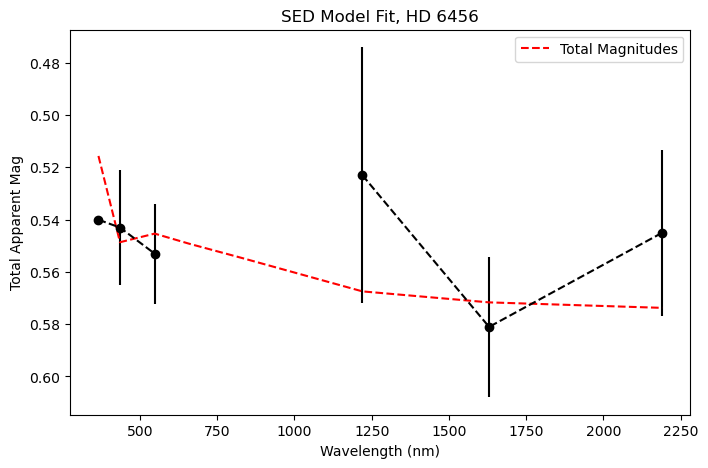

In [106]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(np.flip(x_noG), unumpy.nominal_values(TOT_Mag), yerr = unumpy.std_devs(TOT_Mag), fmt='o--',color='black')

plt.plot(np.flip(x_noG), model_TOT, '--', color='red', label="Total Magnitudes")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Total Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_totMag_fit.pdf"%(directory,target_hd,"newD"))
plt.show()

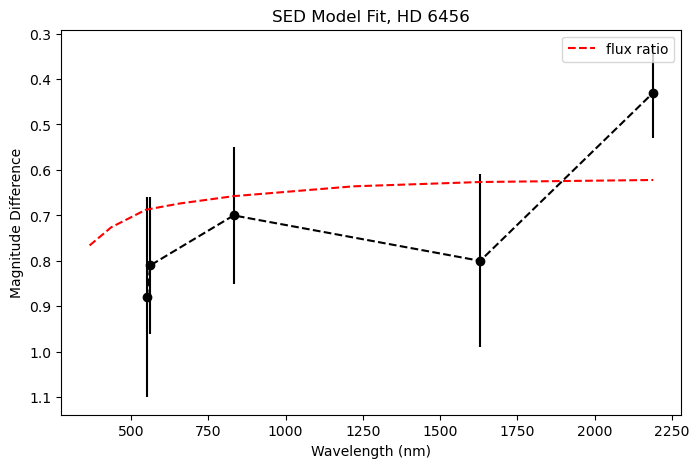

In [107]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(data_wave,unumpy.nominal_values(DiffM),yerr = unumpy.std_devs(DiffM), fmt='o--',color='black')

plt.plot(np.flip(x_noG),model_Diff,'--',color='red', label="flux ratio")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude Difference')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_diffMag_fit.pdf"%(directory,target_hd,"newD"))
plt.show()

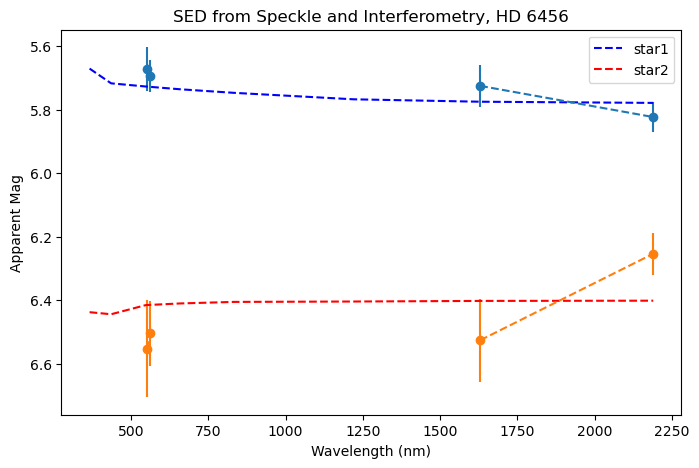

In [108]:
# Individual SEDs
plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--')
plt.errorbar(data_wave,p2,p2err,fmt='o--')

plt.plot(np.flip(x_noG),unumpy.nominal_values(model1),'--',color='blue', label="star1")
plt.plot(np.flip(x_noG),unumpy.nominal_values(model2),'--',color='red', label="star2")

plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,note))
plt.show()

## Chi-Square surface of varying $[\text{Fe/H}]$

In [43]:
def redChi(Chi):
    return np.nansum(Chi**2)/(np.sum(~np.isnan(Chi))-3)

In [110]:
chiparams = result.params.copy()
chiparams

name,value,standard error,relative error,initial value,min,max,vary
age,8.76985793,0.02875667,(0.33%),8.75,7.60000000,inf,True
mass1,2.05080856,0.02858185,(1.39%),2.068564730789984,-inf,inf,True
mass2,3.83724307,0.04128422,(1.08%),3.8626331745876605,-inf,inf,True
feh,-0.46000000,,,-0.46,-inf,inf,False


In [111]:
chiGrid = []

i = 0
for age in np.linspace(3,4.5,50):
    chiGrid.append([])
    for feh in np.linspace(-0.5,0,50):
        chiparams['feh'] = Parameter(name='feh', value=feh)
        chiparams['age'] = Parameter(name='age', value=age)

        Chi = isochrone_model_v3_II(chiparams, unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                            unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                            d_modulus.nominal_value, Av)

        chiGrid[i].append(redChi(Chi))
    i += 1

In [112]:
logChiGrid = np.log10(np.array(chiGrid))

In [113]:
np.min(chiGrid)

2.0444906062215935

In [114]:
X, Y = np.meshgrid(np.linspace(-0.5,0.5,50), np.linspace(6,9,50))

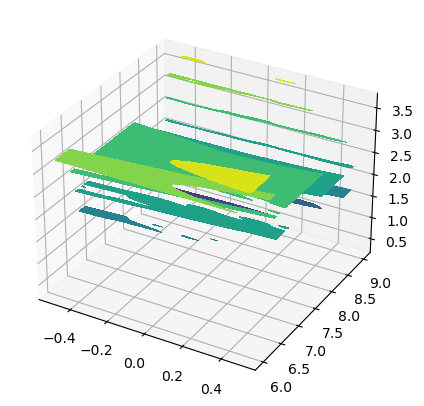

In [115]:
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d


ax = plt.figure().add_subplot(projection='3d')
ax.contourf(X, Y, logChiGrid)

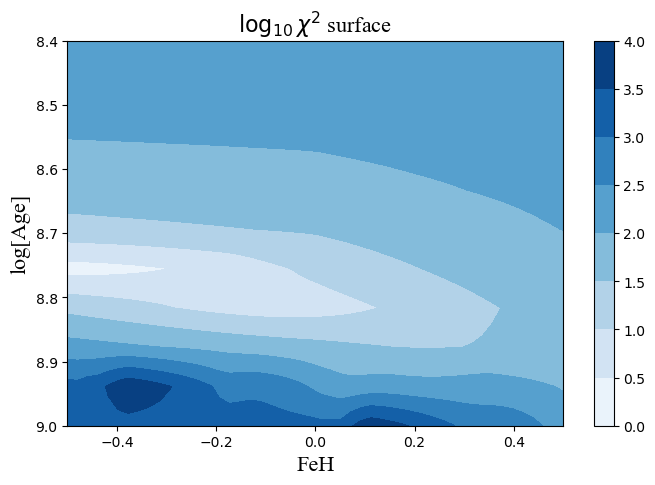

In [116]:
plt.contourf(X,Y,logChiGrid, cmap=cm.Blues)
plt.colorbar()
plt.xlabel("FeH", fontdict=font)
plt.ylabel("log[Age]", fontdict=font)
plt.title(r"$\log_{10}\chi^2$ surface", fontdict=font)
plt.ylim(9,8.4)
plt.savefig("%s/HD_%s_%s_chi2_surface.pdf"%(directory,target_hd,note))

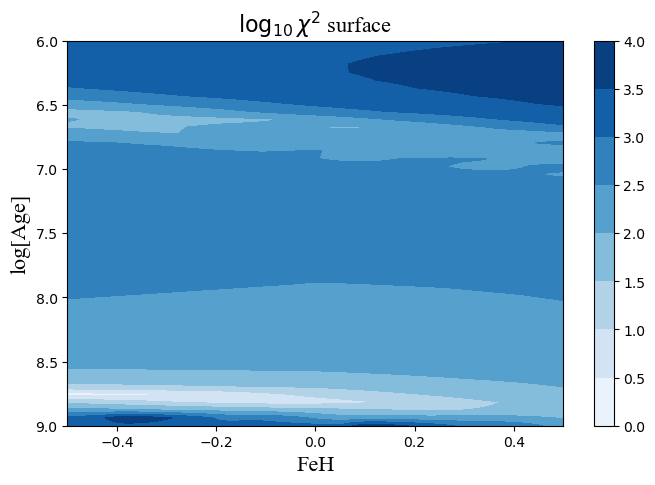

In [117]:
plt.contourf(X,Y,logChiGrid, cmap=cm.Blues)
plt.colorbar()
plt.xlabel("FeH", fontdict=font)
plt.ylabel("log[Age]", fontdict=font)
plt.title(r"$\log_{10}\chi^2$ surface", fontdict=font)
plt.ylim(9,6)
plt.savefig("%s/HD_%s_%s_chi2_surface_full.pdf"%(directory,target_hd,note))

### We investigate of best-fit chi when varying FeH. Fixed age.

### Now we run a MCMC with varying FeH

In [ ]:
emcee_params_2 = chiparams.copy()
emcee_params_2['feh'] = Parameter('feh', value=-0.46, min=-1, max=1)
emcee_params_2['age'] = Parameter('age', value=8.7)
nwalkers = 4*len(emcee_params_2)
steps = 10000
burn = 1000
thin = 25

In [ ]:
minner = Minimizer(isochrone_model_v2, emcee_params_2, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                            unumpy.nominal_values(DiffM),
                                                            unumpy.std_devs(TOT_Mag),
                                                            unumpy.std_devs(DiffM),
                                                            d_modulus.nominal_value, Av),
                   nan_policy='omit')
result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
print(report_fit(result))

In [ ]:
chains_vary_feh = result.flatchain

## save chains (so we don't need to run large ones again)
print(chains_vary_feh.shape)
np.save("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"vary_FeH"),chains_vary_feh)

In [ ]:
## load chains -- NOTE: Could start from here if a run has already been completed
chains_vary_feh = np.load("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"vary_FeH"))

In [ ]:
try:
    emcee_plot = corner.corner(chains_vary_feh,labels=result.var_names)
    #plt.savefig('%s/HD_%s_%s_corner.jpg'%(directory,target_hd,"vary_FeH"))
except:
    print(result.var_names)
    emcee_plot = corner.corner(chains_vary_feh)
    #plt.savefig('%s/HD_%s_%s_corner.png'%(directory,target_hd,"vary_FeH"))

In [ ]:
age_chain = chains_vary_feh[:,0]
mass1_chain = chains_vary_feh[:,1]
mass2_chain = chains_vary_feh[:,2]
feh_chain = chains_vary_feh[:,3]

age_best = np.mean(age_chain)
mass1_best = np.mean(mass1_chain)
mass2_best = np.mean(mass2_chain)
feh_best = np.mean(feh_chain)

age_err = np.std(age_chain)
mass1_err = np.std(mass1_chain)
mass2_err = np.std(mass2_chain)
feh_err = np.std(feh_chain)


In [ ]:
age = ufloat(age_best,age_err)
mass1 = ufloat(mass1_best,mass1_err)
mass2 = ufloat(mass2_best,mass2_err)
feh = ufloat(feh_best,feh_err)
print('Log Age = ', age)
print('M1 (solar) = ', mass1)
print('M2 (solar) = ', mass2)
print('Msum (solar) = ', mass1+mass2)

In [ ]:
a1_best = tracks.generate(mass1_best, age_best, feh_best, return_dict=True)
a2_best = tracks.generate(mass2_best, age_best, feh_best, return_dict=True)

#if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
#    return np.inf
    
model1 = np.array([(a1_best['Mbol'] - bc_grid_U.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                           (a1_best['Mbol'] - bc_grid_B.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_V.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_R.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0], 
                      (a1_best['Mbol'] - bc_grid_I.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_J.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      a1_best["H_mag"]+d_modulus,
                      a1_best["K_mag"]+d_modulus])

model2 = np.array([(a2_best['Mbol'] - bc_grid_U.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                        (a2_best['Mbol'] - bc_grid_B.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_V.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_R.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_I.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_J.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      a2_best["H_mag"]+d_modulus,
                      a2_best["K_mag"]+d_modulus])

In [ ]:
model_TOT = -2.5*np.log10(10**(-0.4*unumpy.nominal_values(model1))+10**(-0.4*unumpy.nominal_values(model2)))
model_Diff = unumpy.nominal_values(model2-model1)

In [ ]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(np.flip(x_noG), unumpy.nominal_values(TOT_Mag), yerr = unumpy.std_devs(TOT_Mag), fmt='o--',color='black')

plt.plot(np.flip(x_noG), model_TOT, '--', color='red', label="Total Magnitudes")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Total Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_totMag_fit.pdf"%(directory,target_hd,"vary_FeH"))
plt.show()

In [ ]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(data_wave,unumpy.nominal_values(DiffM),yerr = unumpy.std_devs(DiffM), fmt='o--',color='black')

plt.plot(np.flip(x_noG),model_Diff,'--',color='red', label="flux ratio")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude Difference')
plt.gca().invert_yaxis()
# plt.savefig("%s/HD_%s_%s_diffMag_fit.pdf"%(directory,target_hd,note))
plt.show()

In [ ]:
# Individual SEDs
plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--')
plt.errorbar(data_wave,p2,p2err,fmt='o--')

plt.plot(np.flip(x_noG),unumpy.nominal_values(model1),'--',color='blue', label="star1")
plt.plot(np.flip(x_noG),unumpy.nominal_values(model2),'--',color='red', label="star2")

plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,"vary_FeH"))
plt.show()

In [ ]:
d_modulus